In [129]:
import numpy as np
from scipy.interpolate import LSQBivariateSpline

import matplotlib.pyplot as plt
from astropy.modeling import models
import astropy.units as u
from astropy.io import fits
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)

from specreduce.utils.synth_data import make_2d_arc_image

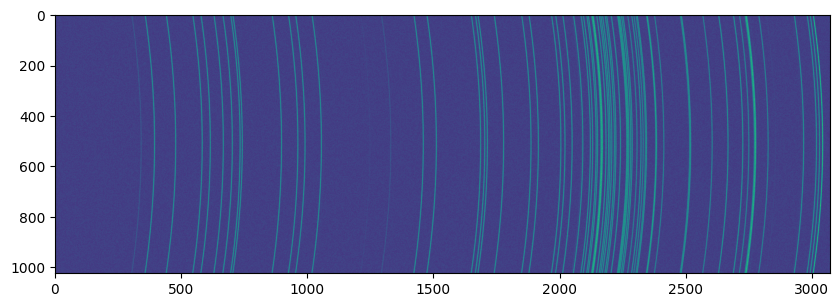

In [98]:
model_deg2 = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
im = make_2d_arc_image(
    nx=3072,
    ny=1024,
    linelists=['HeI', 'ArI'],
    line_fwhm=3,
    tilt_func=model_deg2,
    amplitude_scale=0.01,
    background=100
)
fig = plt.figure(figsize=(10, 6))
plt.imshow(im.data)

In [116]:
y, x = np.indices(im.shape)
noise = np.sqrt(im)
weights = 1 / noise
xknots = np.arange(0, im.shape[1])
yknots = np.linspace(0, im.shape[0], 91)
spline_fit = LSQBivariateSpline(
    x.ravel(), y.ravel(), im.data.ravel(), xknots, yknots, w=weights.ravel(), kx=1, ky=3
)

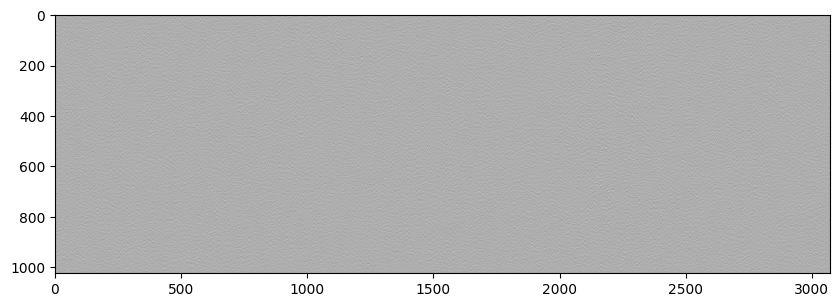

In [134]:
fig = plt.figure(figsize=(10, 6))
zinterp = np.transpose(spline_fit(np.arange(0, im.shape[1]), np.arange(0, im.shape[0])))
norm = ImageNormalize(im.data - zinterp, interval=ZScaleInterval(contrast=0.005), stretch=SqrtStretch())
plt.imshow(im.data - zinterp, cmap='gray', norm=norm)

In [10]:
spline_fit.ev(5, 100)

array(98.79616029)

In [49]:
xknots

array([   0,    1,    2, ..., 2997, 2998, 2999])

In [48]:
y

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [997, 997, 997, ..., 997, 997, 997],
       [998, 998, 998, ..., 998, 998, 998],
       [999, 999, 999, ..., 999, 999, 999]])

In [118]:
fits.writeto("blah.fits", im.data-zinterp, overwrite=True)

In [119]:
fits.writeto("interp.fits", zinterp, overwrite=True)